In [28]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import os
from matplotlib.colors import LogNorm
import h5py

from astropy.io import fits

# Read the map data for the Polar Caps

## The maps are stored in two HEALPix fits files (Nside 128): 
## 1. 'PolarCaps/Ncloud_maps.fits': Contains 2 maps stored as an HDU extension BinTable. First column holds the N_clouds map (fig. 4 of paper) and Second column holds the column-density-weighted N_c map (Fig 7 of paper)
## 2. 'PolarCaps/NHI_cloud_maps.fits': Contains 3 column density maps stored in an HDU extension BinTable. First column is NHI from all clouds in the velocity range [-70,70] km/s. Second column is NHI of clouds in the LVC range (Fig 6 top right). Third column is NHI of clouds in the IVC range (Fig 6, bottom right).

In [18]:
pubdatadir = 'PolarCaps/'

## Read using healpy

NSIDE = 128
ORDERING = NESTED in fits file
INDXSCHM = EXPLICIT
NSIDE = 128
ORDERING = NESTED in fits file
INDXSCHM = EXPLICIT


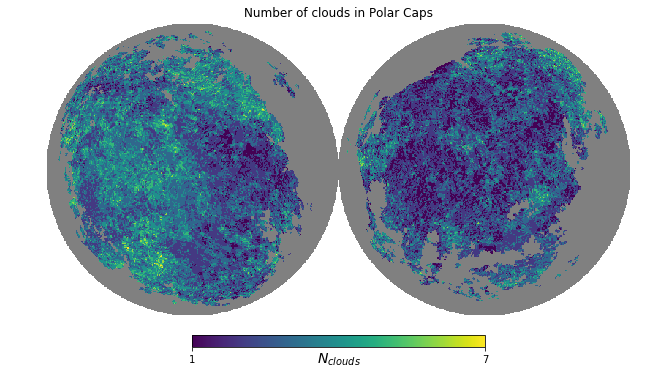

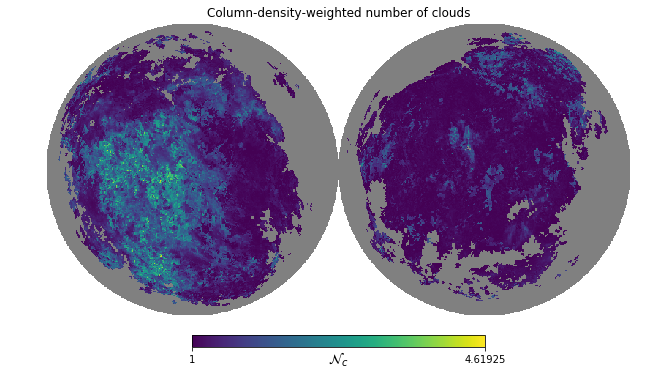

In [31]:
Nclouds_map = hp.read_map(pubdatadir+'Ncloud_maps.fits',field=0,nest=True)
Nc_map = hp.read_map(pubdatadir+'Ncloud_maps.fits',field=1,nest=True)

hp.orthview(Nclouds_map, rot = [0,90,90], nest=True,\
            unit = '$N_{clouds}$', title = 'Number of clouds in Polar Caps')
plt.show()
hp.orthview(Nc_map, rot = [0,90,90],nest=True, \
            unit = '$\mathcal{N}_c$', title = 'Column-density-weighted number of clouds')
plt.show()

## Map contents can also be read using astropy's fits.open:

In [29]:
hdulist = fits.open(pubdatadir+'NHI_cloud_maps.fits')
print hdulist
hdulist[1].header

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7ff3e734ccd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7ff3e734cad0>]


XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   16 / length of dimension 1                          
NAXIS2  =                83374 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    4 / number of table fields                         
TTYPE1  = 'PIXEL   '                                                            
TFORM1  = 'J       '                                                            
TTYPE2  = 'NHI_clouds'                                                          
TFORM2  = 'E       '                                                            
TUNIT2  = 'cm^-2   '        

# Data on individual cloud properties
## The hdf5 file 'PolarCaps/clouds_db.hdf5' holds properties of the entire sample  of  clouds  (including  velocities  excluded from the analysis in Section 4 of the paper). The file contains 6 columns (arrays) of size 477711. Each element of the array corresponds to a distinct cloud identified within the sky region.

## The columns are:
### cloudNH: cloud column density
### Ngaussians: the number of Gaussian components that belong to this cloud. Can be used to discard 'spurious' clouds with too few Gaussian components.
### Nmaxima: the number of peaks in the cloud spectrum. Can be used to investigate unresolved velocity structure.
### centroids: centroid velocity of the cloud spectrum, eq. 2
### hpxpix: the HEALPix pixel where the cloud is located. Nested ordering, Nside 128.
### std: second moment of the cloud spectrum, eq. 3. Can be used as estimate of breadth (in velocity) of cloud spectrum.

In [33]:
f = h5py.File(datadir+'clouds_db.hdf5', 'r')

# Explore the datafile contents

In [5]:
def printname(name):
    print(name)

print 'Attributes:'
print f['clouds'].attrs.items()

print 'Data structure:'
f.visit(printname)


Attributes:
[(u'Nside', 128), (u'NEST', True)]
Data structure:
clouds
clouds/Ngaussians
clouds/Nmaxima
clouds/centroids
clouds/cloudNH
clouds/hpxpix
clouds/std


In [16]:
f['clouds']['Nmaxima'].shape

(477711,)

# Make Nclouds map counting clouds at all velocities

In [6]:
Nside_low = f['clouds'].attrs['Nside']

Ncmap_all = np.zeros(hp.nside2npix(Nside_low))+hp.pixelfunc.UNSEEN

# find unique pixels with cloud info
uniquepix = np.unique(f['clouds']['hpxpix'][:])

# Count number of clouds in each pixel
for ii,ipix in enumerate(uniquepix):
    
    condition = f['clouds']['hpxpix'][:]==ipix
    N = len(f['clouds']['hpxpix'][:][condition])
    Ncmap_all[int(ipix)] = N
    
    # Keep track of progress
    print '{0} out of {1}\r'.format(ii,len(uniquepix)),


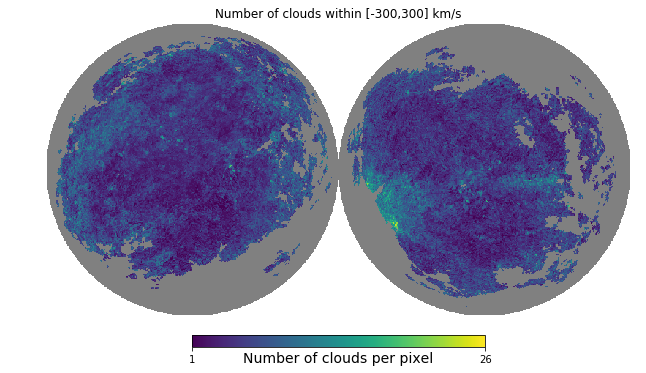

In [7]:
hp.orthview(Ncmap_all, rot = [0,90], nest=True, \
            unit = 'Number of clouds per pixel', title = 'Number of clouds within [-300,300] km/s')


# Let's apply the velocity cut to exclude HVCs, and also discard clouds with too few Gaussian components

In [34]:
# Define an array to populate with values for each healpix pixel of the sky footprint
Ncmap = np.zeros(hp.nside2npix(Nside_low))+hp.pixelfunc.UNSEEN

# find unique pixels with cloud info
uniquepix = np.unique(f['clouds']['hpxpix'][:])

# Set the velocity range of interest (can be any set of values from -300 to 300 km/s)
vmin, vmax = -70.851, 69.563 # these are the velocities that correspond to the nearest channels in the Hi4PI data

# Select clouds within the specified velocity range
cloud_centroid_in_range = np.logical_and(vmin <= f['clouds']['centroids'][:], f['clouds']['centroids'][:] <= vmax)

# Set a lower limit on the number of Gaussians that a cloud can have and still be considered non-spurious
Ngauscut = 20
# Select clouds above this threshold
clouds_above_Ngauscut = f['clouds']['Ngaussians'][:] >= Ngauscut

# Count number of clouds in each healpix pixel
for ii,ipix in enumerate(uniquepix):
    
    # Find the indices where clouds of this pixel exist in the original dataset
    clouds_in_pixel = f['clouds']['hpxpix'][:]==ipix
    
    # Select only clouds that satisfy all cuts
    condition = np.logical_and(np.logical_and(cloud_centroid_in_range,clouds_in_pixel), clouds_above_Ngauscut)
    
    # Count the number of clouds in this pixel that satisfy the cuts
    N = len(f['clouds']['hpxpix'][:][condition])
    # Save the value in the Ncmap array
    Ncmap[int(ipix)] = N
    
    # Keep track of progress
    print '{0} out of {1}\r'.format(ii,len(uniquepix)),

# This is the version of the Nc map that was published

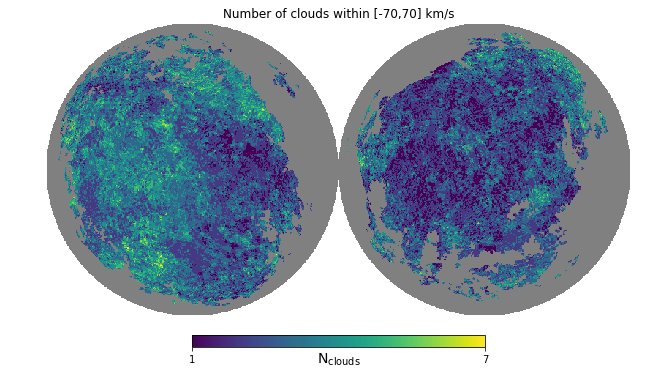

In [38]:
cmap = plt.get_cmap('viridis', 7)

hp.orthview(Ncmap, rot = [0,90,90], nest=True, \
            unit = r'N$\rm _{clouds}$', title = 'Number of clouds within [-70,70] km/s')


## Sanity check: for the selected velocity range, the Ncmap we just made should exactly match the Nclouds map that's provided in healpix fits format

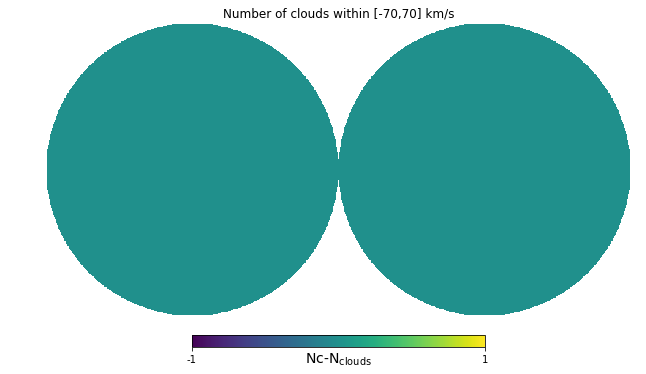

In [39]:
hp.orthview(Nclouds_map-Ncmap, rot = [0,90,90], nest=True, \
            unit = r'Nc-N$\rm _{clouds}$', title = 'Number of clouds within [-70,70] km/s')

In [40]:
f.close()

# Explore data in the BICEP field

## Read the NHI map

NSIDE = 128
ORDERING = NESTED in fits file
INDXSCHM = EXPLICIT


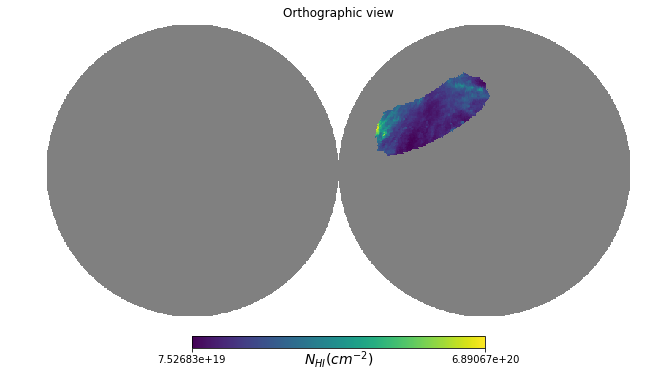

In [41]:
NHI_clouds = hp.read_map('BICEP/NHI_cloud_maps.fits', field = 0, nest=True)

hp.orthview(NHI_clouds,rot = [0,90,90],nest=True, unit = '$N_{HI} (cm^{-2})$')

In [63]:
pubdatadir = 'BICEP/'

f = h5py.File(pubdatadir+'clouds_db.hdf5', 'r')

## Plot cloud centroid vs second moment of cloud spectrum

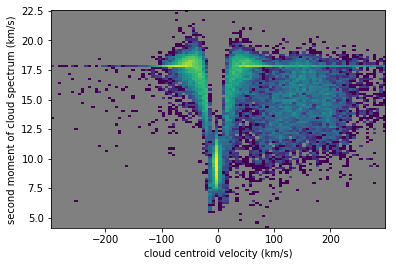

In [50]:
plt.hist2d(f['clouds']['centroids'][:],f['clouds']['std'][:], bins = 100, norm= LogNorm())
plt.xlabel('cloud centroid velocity (km/s)')
plt.ylabel('second moment of cloud spectrum (km/s)')
plt.show()

## Remove spurious 'clouds' by placing a cut on the minimum acceptable number of Gaussians

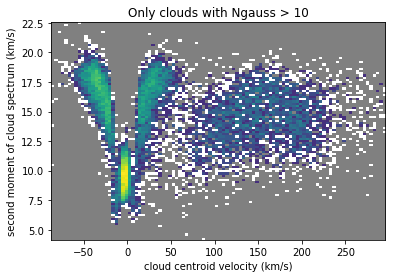

In [56]:
Ngauscut = 10
Ngaus_threshold = f['clouds']['Ngaussians'][:] >= Ngauscut
plt.hist2d(f['clouds']['centroids'][:][Ngaus_threshold],f['clouds']['std'][:][Ngaus_threshold], bins = 100, norm= LogNorm())
plt.xlabel('cloud centroid velocity (km/s)')
plt.ylabel('second moment of cloud spectrum (km/s)')
plt.title('Only clouds with Ngauss > %d'%Ngauscut)
plt.show()

## Let's create a map of the number of clouds in the velocity range that mostly hosts the Magellanic Stream

In [68]:
# Define an array to populate with values for each healpix pixel of the sky footprint
Ncmap = np.zeros(hp.nside2npix(Nside_low))+hp.pixelfunc.UNSEEN

# find unique pixels with cloud info
uniquepix = np.unique(f['clouds']['hpxpix'][:])

# Set the velocity range of interest (can be any set of values from -300 to 300 km/s)
vmin, vmax = 50, 250

# Select clouds within the specified velocity range
cloud_centroid_in_range = np.logical_and(vmin <= f['clouds']['centroids'][:], f['clouds']['centroids'][:] <= vmax)

# Set a lower limit on the number of Gaussians that a cloud can have and still be considered non-spurious
Ngauscut = 20
# Select clouds above this threshold
clouds_above_Ngauscut = f['clouds']['Ngaussians'][:] >= Ngauscut

# Count number of clouds in each healpix pixel
for ii,ipix in enumerate(uniquepix):
    
    # Find the indices where clouds of this pixel exist in the original dataset
    clouds_in_pixel = f['clouds']['hpxpix'][:]==ipix
    
    # Select only clouds that satisfy all cuts
    condition = np.logical_and(np.logical_and(cloud_centroid_in_range,clouds_in_pixel), clouds_above_Ngauscut)
    
    # Count the number of clouds in this pixel that satisfy the cuts
    N = len(f['clouds']['hpxpix'][:][condition])
    # Save the value in the Ncmap array
    Ncmap[int(ipix)] = N
    
    # Keep track of progress
    print '{0} out of {1}\r'.format(ii,len(uniquepix)),

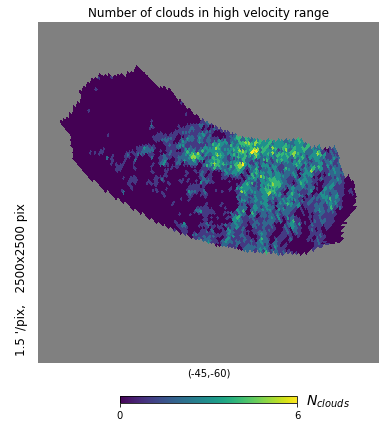

In [70]:
hp.gnomview(Ncmap,rot = [-45,-60,0], reso = 1.5, xsize = 2500,\
               nest = True, title='Number of clouds in high velocity range', unit = '$N_{clouds}$')